## ⚠️ Âmes sensibles s'abstenir : Installer TensorFlow GPU sur Windows

Ce guide explique comment installer **TensorFlow 2.10.0 avec support GPU natif sur Windows**, en respectant les versions compatibles des dépendances NVIDIA.  

---

### ✅ Prérequis

- **Python** : version **3.7 à 3.10**  
- **TensorFlow** : **2.10.0** (dernière version officielle compatible GPU sous Windows natif)  
- **NVIDIA CUDA Toolkit** : **11.2**  
- **NVIDIA cuDNN** : **8.1**  
- **GPU NVIDIA** avec pilotes à jour  

---

### 🔧 Étapes d'installation

#### 1. Créer un environnement virtuel (recommandé)

```
python -m venv tf-gpu
.\tf-gpu\Scripts\activate
```

#### 2. Installer TensorFlow GPU 2.10.0

```
pip install tensorflow==2.10.0
```

#### 3. Installer CUDA 11.2 et cuDNN 8.1

- [**CUDA 11.2**](https://developer.nvidia.com/cuda-11.2.0-download-archive)
- [**cuDNN 8.1**](https://developer.nvidia.com/rdp/cudnn-archive)

#### 4. Utilisation de ```add_dll_directory```

Utilisez bien ceci pour pouvoir utiliser le GPU pour l'entrainement des modeles :

```
import os
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")
```

---

In [1]:
import os 
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import splitfolders

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, BatchNormalization,Input,concatenate
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

In [10]:
# Path where our data is located
base_path = "traitement image/data/mediapipe_images/"

# Dictionary to save our 36 classes
categories = {  0: "0",
                1: "1",
                2: "2",
                3: "3",
                4: "4",
                5: "5",
                6: "6",
                7: "7",
                8: "8",
                9: "9",
                10: "a",
                11: "b",
                12: "c",
                13: "d",
                14: "e",
                15: "f",
                16: "g",
                17: "h",
                18: "i",
                19: "j",
                20: "k",
                21: "l",
                22: "m",
                23: "n",
                24: "o",
                25: "p",
                26: "q",
                27: "r",
                28: "s",
                29: "t",
                30: "u",
                31: "v",
                32: "w",
                33: "x",
                34: "y",
                35: "z",
            }

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[re.search("_", x).start() + 1 : re.search("_", x).start() + 2]
        + "/"
        + x
    )
    return df


# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [11]:
df

,filename,category
0,l/hand4_l_bot_seg_5_cropped.jpeg,21
1,d/hand2_d_top_seg_3_cropped.jpeg,13
2,f/hand4_f_bot_seg_5_cropped.jpeg,15
3,1/hand1_1_left_seg_4_cropped.jpeg,1
4,2/hand5_2_dif_seg_2_cropped.jpeg,2
...,...,...
1618,l/hand2_l_dif_seg_3_cropped.jpeg,21
1619,2/hand4_2_bot_seg_2_cropped.jpeg,2
1620,3/hand4_3_bot_seg_1_cropped.jpeg,3
1621,1/hand1_1_right_seg_5_cropped.jpeg,1


In [12]:
print("number of elements = ", len(df))

number of elements =  1623


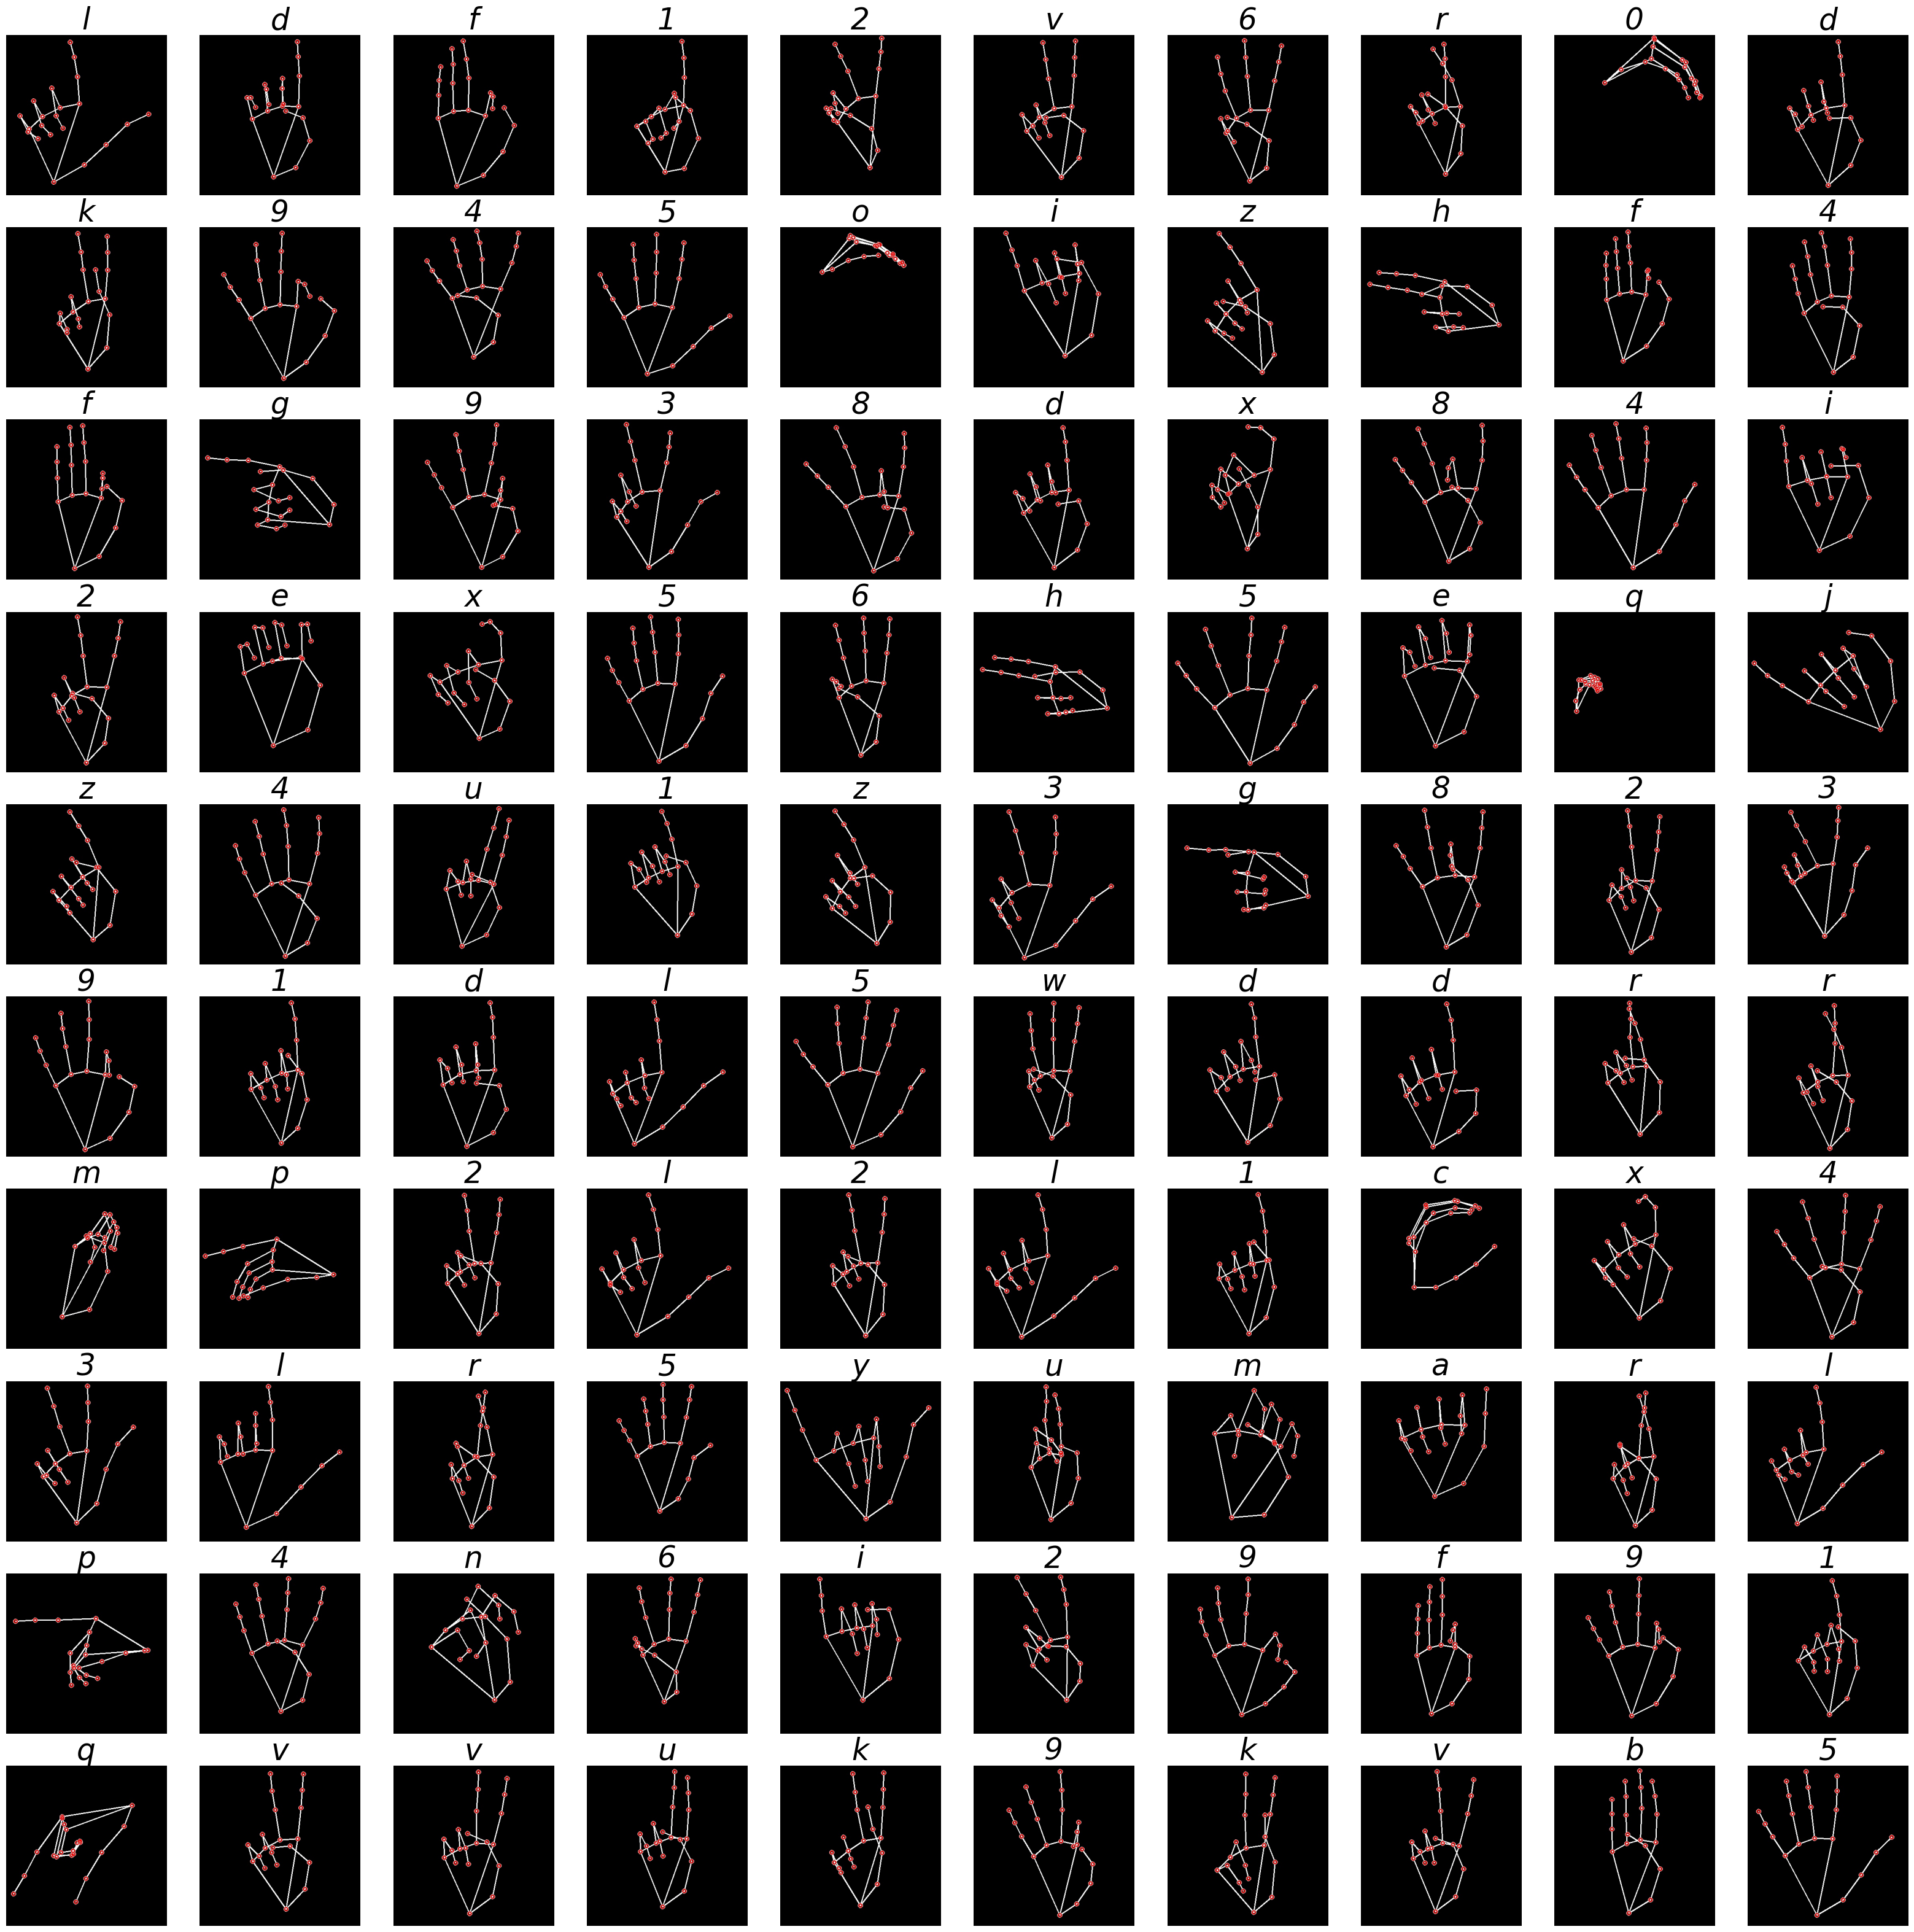

In [13]:
plt.figure(figsize=(40,40))

for i in range(100):
    path = base_path + df.filename[i]
    img = plt.imread(path)
    plt.subplot(10,10, i + 1)
    plt.imshow(img)
    plt.title(categories[df.category[i]],fontsize=35,fontstyle='italic')
    plt.axis("off")

C:\Users\remyl\AppData\Local\Temp\ipykernel_12280\842432032.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)


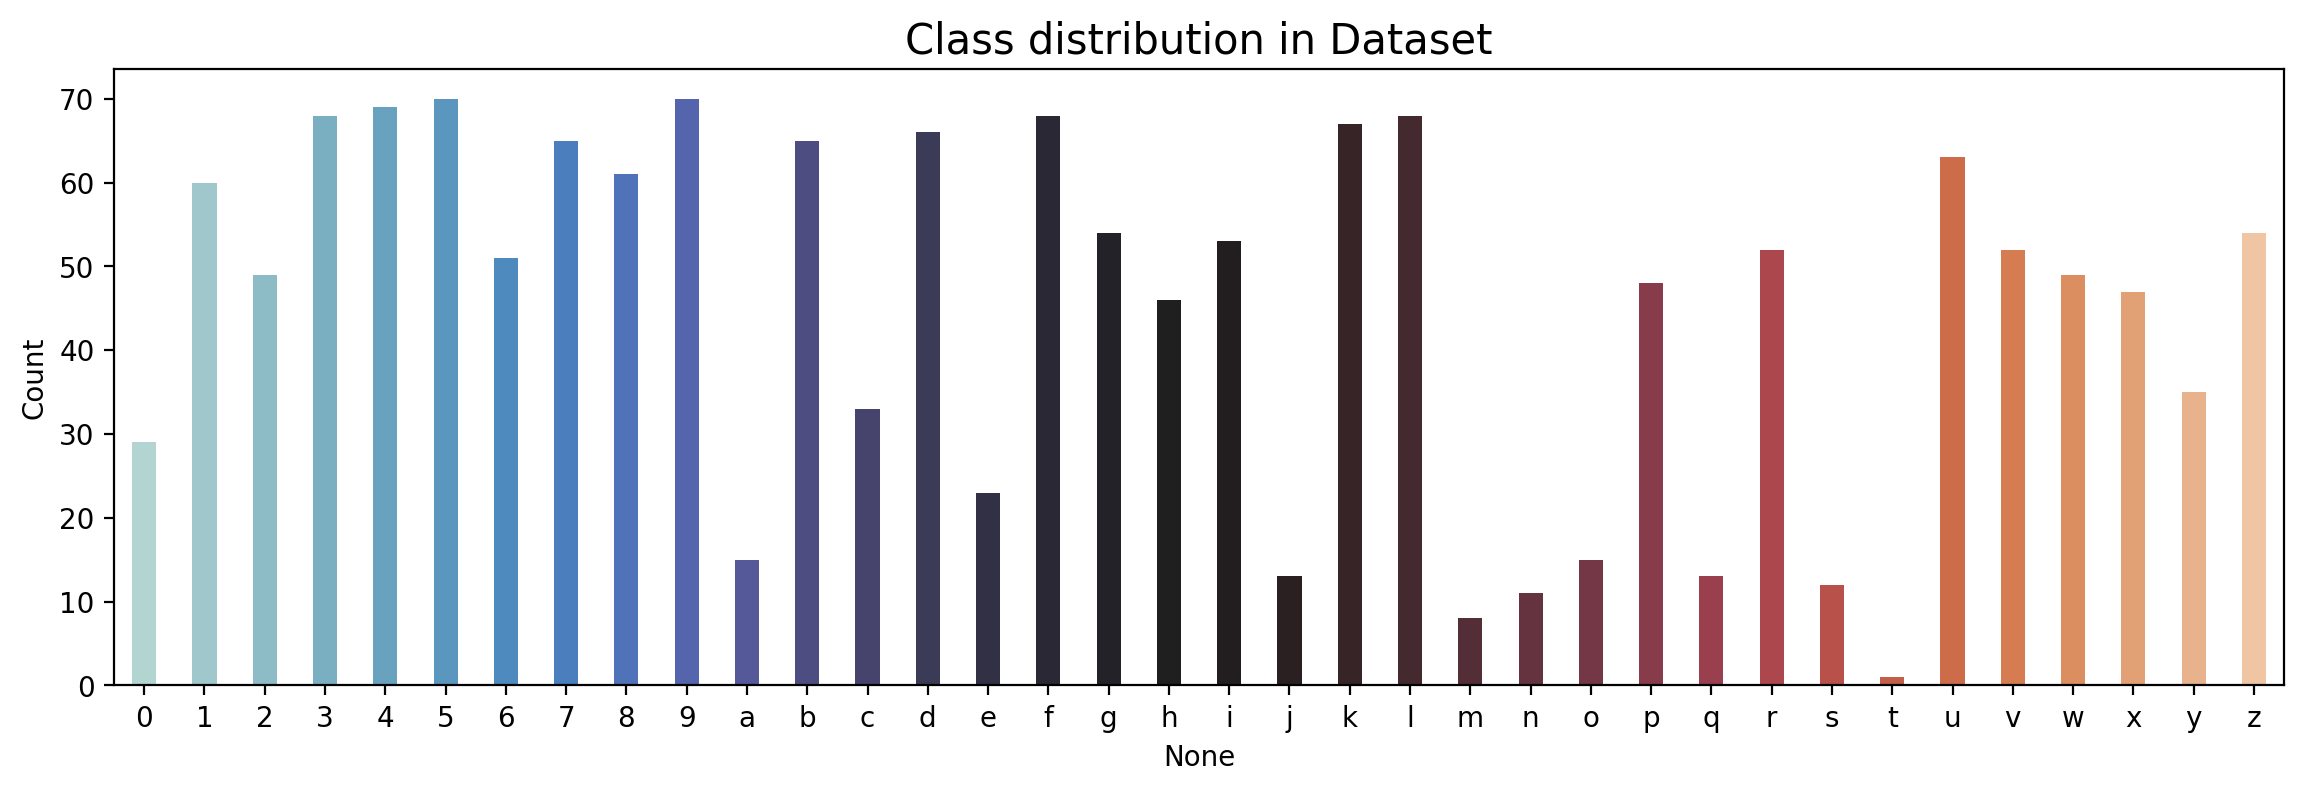

In [14]:
label,count = np.unique(df.category,return_counts=True)
uni = pd.DataFrame(data=count,index=categories.values(),columns=['Count'])

plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)
plt.show()

In [19]:
splitfolders.ratio('traitement image/data/mediapipe_images',output='traitement image/working/', seed=1333, ratio=(0.8,0.1,0.1))

In [20]:
import shutil
shutil.rmtree("traitement image/working/train/asl_dataset")
shutil.rmtree("traitement image/working/val/asl_dataset")
shutil.rmtree("traitement image/working/test/asl_dataset")

In [21]:
datagen = ImageDataGenerator(rescale= 1.0 / 255)

In [22]:
train_path = 'traitement image/working/train'
val_path = 'traitement image/working/val'
test_path = 'traitement image/working/test'

batch = 32
image_size = 200
img_channel = 3
n_classes = 36

In [23]:
train_data = datagen.flow_from_directory(directory= train_path, 
                                         target_size=(image_size,image_size), 
                                         batch_size = batch, 
                                         class_mode='categorical')

val_data = datagen.flow_from_directory(directory= val_path, 
                                       target_size=(image_size,image_size), 
                                       batch_size = batch, 
                                       class_mode='categorical',
                                       )

test_data = datagen.flow_from_directory(directory= test_path, 
                                         target_size=(image_size,image_size), 
                                         batch_size = batch, 
                                         class_mode='categorical',
                                         shuffle= False)

Found 1285 images belonging to 36 classes.
Found 146 images belonging to 36 classes.
Found 192 images belonging to 36 classes.


In [ ]:
model = Sequential()
# Block 1
model.add(Conv2D(32,3,activation='relu',padding='same',input_shape = (image_size,image_size,img_channel)))
model.add(Conv2D(32,3,activation='relu',padding='same'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.3))

#Block 3
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(36, activation='softmax'))



model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      36928     
                                                        

In [25]:
early_stoping = EarlyStopping(monitor='val_loss', 
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True, 
                              verbose = 0)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy', 
                                         patience = 2, 
                                         factor=0.5 , 
                                         verbose = 1)

In [26]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [27]:
asl_class = model.fit(train_data, 
                      validation_data= val_data, 
                      epochs=30, 
                      callbacks=[early_stoping,reduce_learning_rate],
                      verbose = 1)

Epoch 1/30
41/41 [==============================] - 58s 1s/step - loss: 2.2547 - accuracy: 0.4187 - val_loss: 1.0166 - val_accuracy: 0.7877 - lr: 0.0010
Epoch 2/30
41/41 [==============================] - 51s 1s/step - loss: 0.6650 - accuracy: 0.7953 - val_loss: 0.4882 - val_accuracy: 0.8630 - lr: 0.0010
Epoch 3/30
41/41 [==============================] - 50s 1s/step - loss: 0.3252 - accuracy: 0.8965 - val_loss: 0.4295 - val_accuracy: 0.8973 - lr: 0.0010
Epoch 4/30
41/41 [==============================] - 50s 1s/step - loss: 0.2208 - accuracy: 0.9307 - val_loss: 0.3502 - val_accuracy: 0.8973 - lr: 0.0010
Epoch 5/30
41/41 [==============================] - 50s 1s/step - loss: 0.1383 - accuracy: 0.9556 - val_loss: 0.3887 - val_accuracy: 0.9041 - lr: 0.0010
Epoch 6/30
41/41 [==============================] - 49s 1s/step - loss: 0.1122 - accuracy: 0.9634 - val_loss: 0.3014 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 7/30
41/41 [==============================] - 49s 1s/step - loss: 0.0965 - a

In [ ]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_data , verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

The accuracy of the model for training data is: 99.76653456687927
The Loss of the model for training data is: 0.014027574099600315
The accuracy of the model for validation data is: 91.78082346916199
The Loss of the model for validation data is: 0.30143940448760986


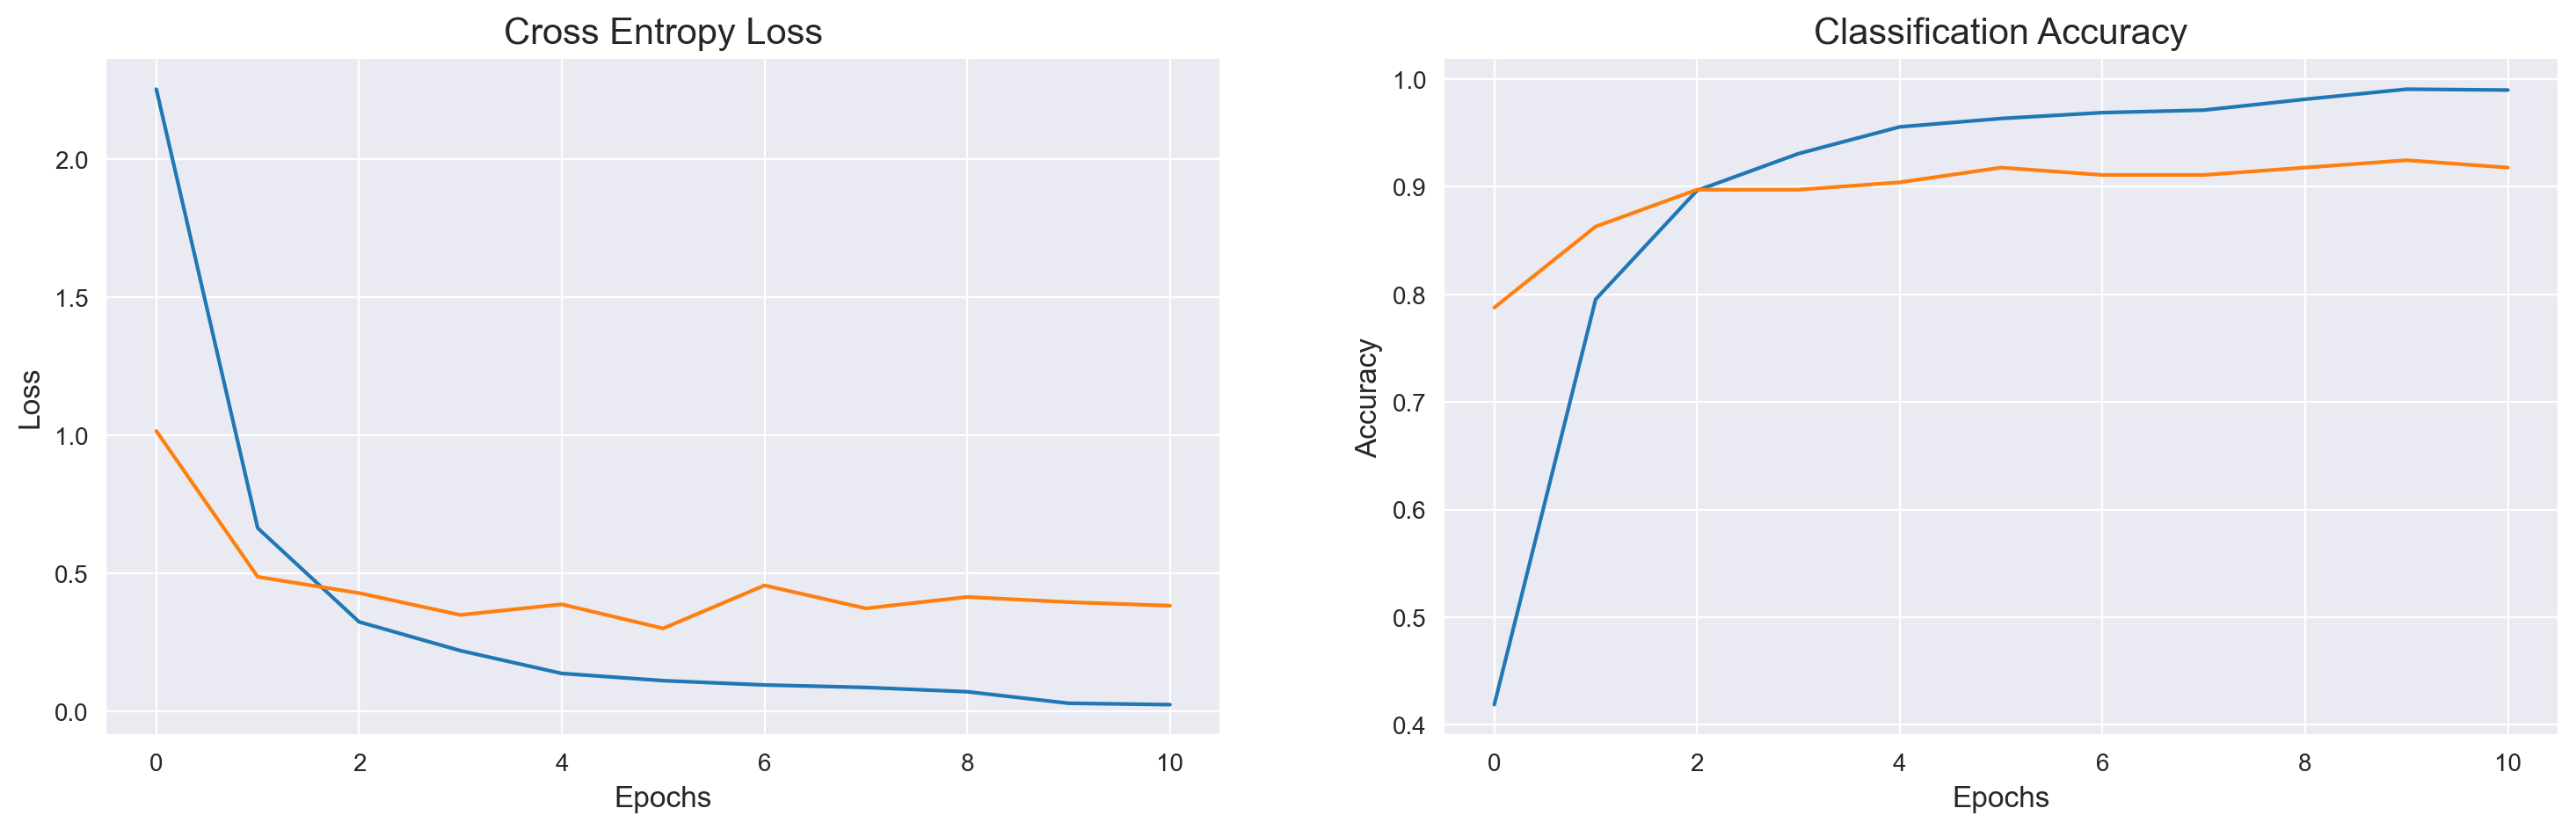

In [29]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(asl_class.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [30]:
# prediction
result = model.predict(test_data,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_data.labels

# Evaluvate
loss,acc = model.evaluate(test_data,verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 89.58333134651184
The Loss of the model for testing data is: 0.4164454936981201


In [31]:
p = y_pred
y = y_true
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 172
Incorrect predicted classes: 20


In [32]:
print(classification_report(y_true, y_pred,target_names= categories.values()))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         6
           2       0.75      1.00      0.86         6
           3       1.00      1.00      1.00         8
           4       0.83      0.62      0.71         8
           5       0.75      0.86      0.80         7
           6       1.00      0.67      0.80         6
           7       1.00      0.86      0.92         7
           8       1.00      0.86      0.92         7
           9       0.88      1.00      0.93         7
           a       1.00      0.50      0.67         2
           b       0.86      0.86      0.86         7
           c       0.80      1.00      0.89         4
           d       1.00      1.00      1.00         8
           e       0.75      1.00      0.86         3
           f       0.89      1.00      0.94         8
           g       0.83      0.83      0.83         6
           h       1.00    

c:\Users\remyl\Desktop\IPSSI\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\remyl\Desktop\IPSSI\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\remyl\Desktop\IPSSI\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

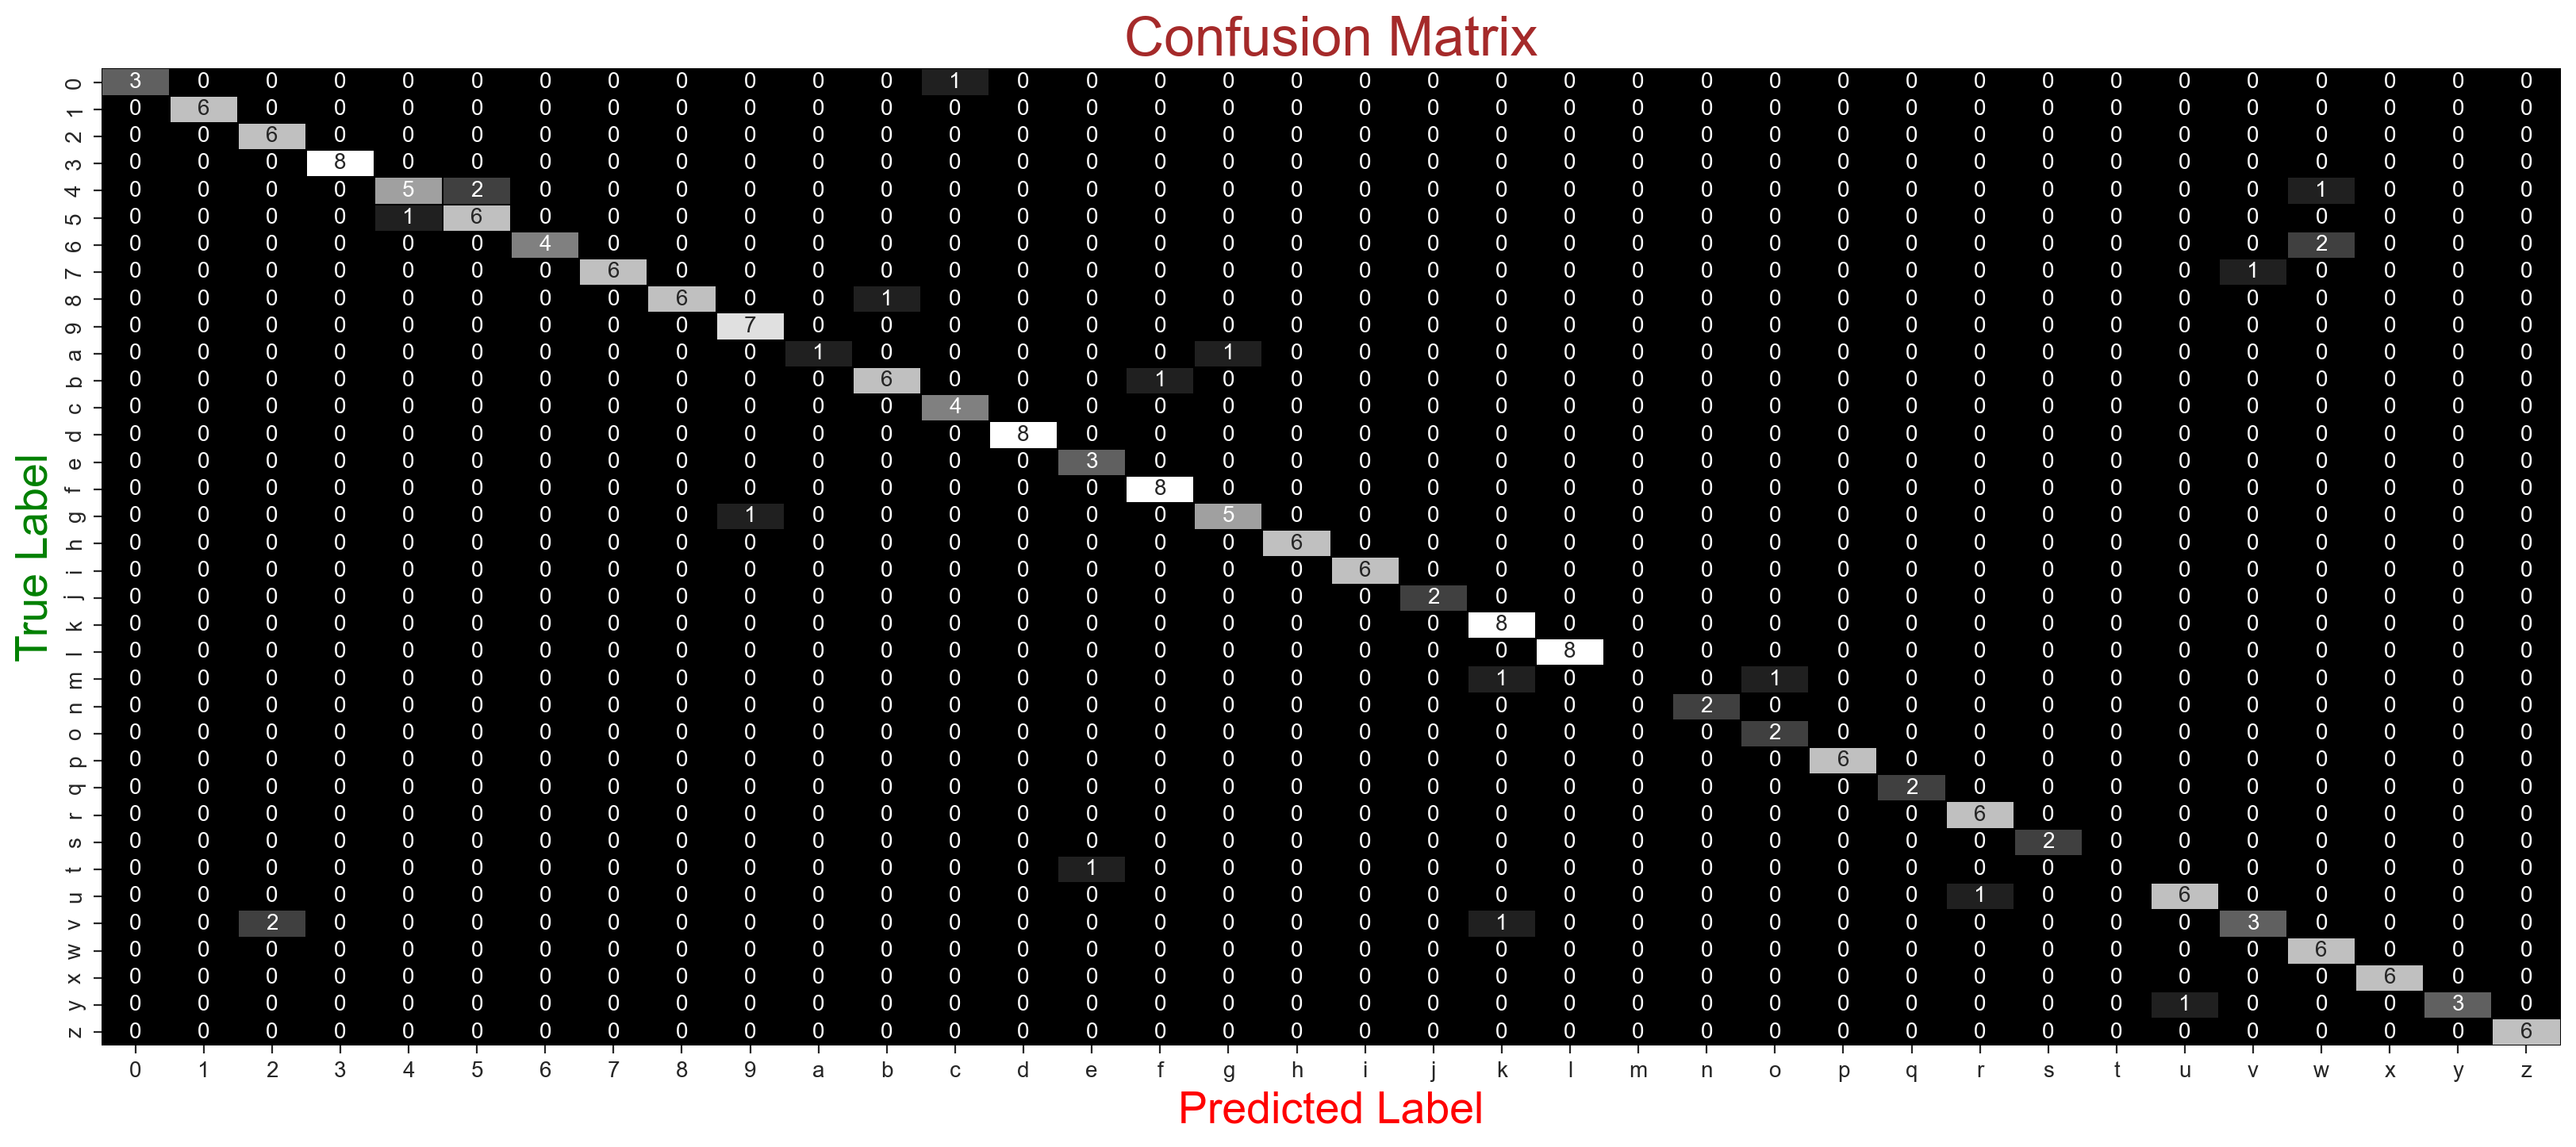

In [33]:
sns.set_style('ticks')

confusion_mtx = confusion_matrix(y_true,y_pred) 

f,ax = plt.subplots(figsize = (20,8),dpi=200)

sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.1, cmap = "gist_yarg_r", 
            linecolor="black", fmt='.0f', ax=ax, 
            cbar=False, xticklabels=categories.values(), 
            yticklabels=categories.values())

plt.xlabel("Predicted Label",fontdict={'color':'red','size':20})
plt.ylabel("True Label",fontdict={'color':'green','size':20})
plt.title("Confusion Matrix",fontdict={'color':'brown','size':25})

plt.show()

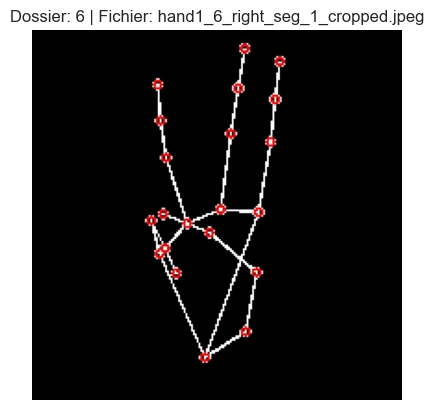

1/1 [==============================] - 0s 110ms/step
Classe prédite : 6


In [100]:
import os
import random
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

base_path = "traitement image/data/mediapipe_images/"
folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f)) and f != "asl_dataset"]
chosen_folder = random.choice(folders)
folder_path = os.path.join(base_path, chosen_folder)
images = os.listdir(folder_path)
chosen_image = random.choice(images)
img_path = os.path.join(folder_path, chosen_image)

img = load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.title(f"Dossier: {chosen_folder} | Fichier: {chosen_image}")
plt.axis("off")
plt.show()

img_array = img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]
print("Classe prédite :", categories[pred_class])

In [57]:
model.save("vector.h5")